In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [11]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [12]:
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)
df.reset_index(inplace=True)
df.rename(columns={df.columns[0]: "ds"}, inplace=True)  # Prophet attend "ds" pour les dates
detected_freq = pd.infer_freq(df["ds"]) or "MS"
# Exclure la colonne "ds" pour identifier toutes les colonnes à prédire
target_columns = [col for col in df.columns if col != "ds"]

# Dictionnaire pour stocker les prédictions de chaque colonne
forecast_results = {}




02:24:49 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model for TRFVOLUSM227NFWA...


02:24:49 - cmdstanpy - INFO - Chain [1] done processing


📌 MSE for TRFVOLUSM227NFWA: 0.3262


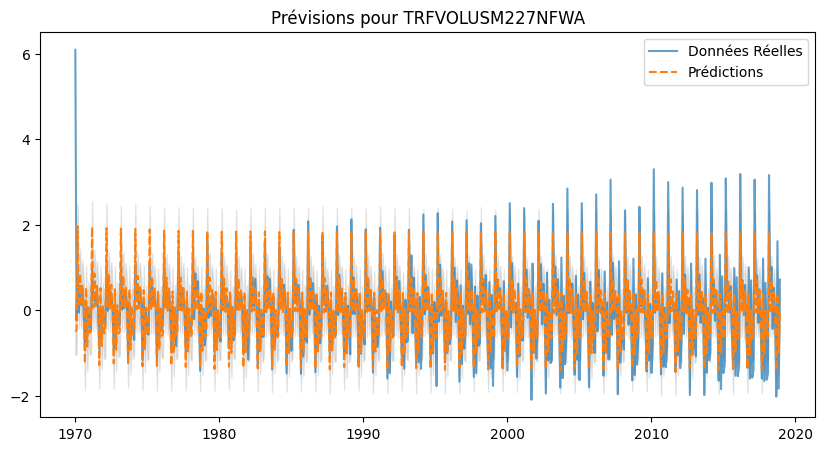

Toutes les prédictions ont été enregistrées.


In [13]:
# Boucle sur chaque colonne cible
for column in target_columns:
    print(f"Training Prophet model for {column}...")

    # Créer un DataFrame temporaire avec seulement la colonne cible et la date
    temp_df = df[["ds", column]].rename(columns={column: "y"})

    # Séparer train/test (80/20)
    split_index = int(len(temp_df) * 0.8)
    train_df = temp_df.iloc[:split_index]
    test_df = temp_df.iloc[split_index:]

    # Entraîner Prophet
    model = Prophet()
    model.fit(train_df)

    # Créer un dataframe pour les futures prédictions
    future = model.make_future_dataframe(periods=len(test_df), freq=detected_freq)

    # Faire les prédictions
    forecast = model.predict(future)

    # EXTRAIRE SEULEMENT LES PREDICTIONS CORRESPONDANT À LA PÉRIODE DE TEST
    y_true = test_df["y"].values
    y_pred = forecast["yhat"].iloc[-len(test_df):].values  # Prendre les prédictions sur la période de test

    # ✅ Calculer l'erreur MSE
    mse = mean_squared_error(y_true, y_pred)
    print(f"📌 MSE for {column}: {mse:.4f}")

    # Sauvegarder les résultats
    forecast_results[column] = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(temp_df["ds"], temp_df["y"], label="Données Réelles", alpha=0.7)
    plt.plot(forecast["ds"], forecast["yhat"], label="Prédictions", linestyle="dashed")
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        color="gray",
        alpha=0.2,
    )
    plt.title(f"Prévisions pour {column}")
    plt.legend()
    plt.show()

# Sauvegarder les prévisions de toutes les colonnes
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_prophet_{col}.csv", index=False)

print("Toutes les prédictions ont été enregistrées.")


In [8]:
train_df

,ds,y
0,1992-01-01,2.576169
1,1992-02-01,0.021344
2,1992-03-01,0.062858
3,1992-04-01,0.100912
4,1992-05-01,0.220264
...,...,...
254,2013-03-01,0.652699
255,2013-04-01,-0.269252
256,2013-05-01,0.759943
257,2013-06-01,-0.272712


In [9]:
test_df

,ds,y
259,2013-08-01,0.080155
260,2013-09-01,-0.845255
261,2013-10-01,0.235832
262,2013-11-01,0.436482
263,2013-12-01,1.965571
...,...,...
319,2018-08-01,-0.146441
320,2018-09-01,-0.552929
321,2018-10-01,0.206426
322,2018-11-01,0.645780
